# Domain Adaptation

This work is faced with data from two different spectral archives (**domains**).
Data from Ondrejov have much more details.
For example more double peak spectra can be observed.

In [1]:
%matplotlib inline

In [2]:
import csv
import astropy.io.fits as fits
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib.pyplot as plt
import numpy as np
import spectraldl.lamost as lamost
import spectraldl.ondrejov as ondrejov
import spectraldl.utils as utils
import spectraldl.preprocessing as preprocessing

In [3]:
with open('data/cross-matched.csv', newline='') as f:
    paths = [tuple(row) for row in csv.reader(f)]

In [4]:
def read_spectra(paths):
    start, end = 6500, 6600
    spectra = {}
    for ond_path, lam_path in paths:
        with fits.open(ond_path) as ond_hdulist:
            name = ondrejov.get_object_name(ond_hdulist)
            ond_waves, ond_fluxes = utils.cut_spectrum(
                *ondrejov.get_spectrum(ond_hdulist),
                start, end
            )
        with fits.open(lam_path) as lam_hdulist:
            lam_waves, lam_fluxes = utils.cut_spectrum(
                *lamost.get_spectrum(lam_hdulist),
                start, end
            )
        spectra[name] = {
            'ond': {'waves': ond_waves, 'fluxes': ond_fluxes},
            'lam': {'waves': lam_waves, 'fluxes': lam_fluxes}
        }
    return spectra
    
spectra = read_spectra(paths)

## Air to Vacuum

Wavelengths of spectra in Ondřejov CCD700 archive are stored in air form.
LAMOST stores wavelengths in vacuum form.
Therefore Onřejov's spectra are going to be converted.
For conversion mathematic refer to http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion.
`air2vacuum` function was implemented in `spectraldl.utils` module:

    def air2vacuum(air_waves):
        # http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion
        vac_waves = np.zeros_like(air_waves)
        for idx, wave in enumerate(air_waves):
            s = (10 ** 4) / wave
            n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 \ 
                    - s ** 2) + 0.0001599740894897 / (38.92568793293 - s ** 2)
            vac_waves[idx] = wave * n
        return vac_waves


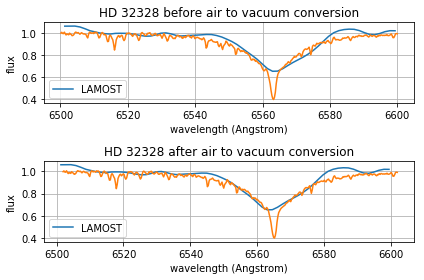

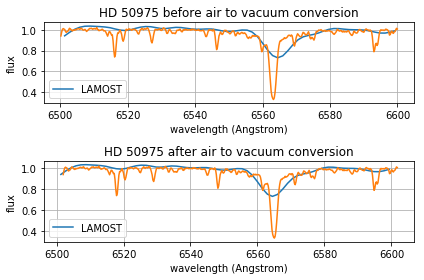

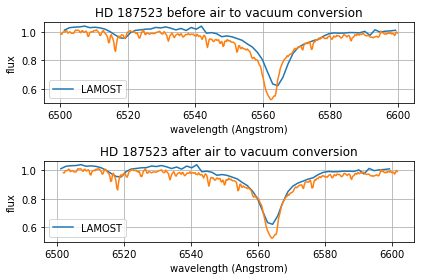

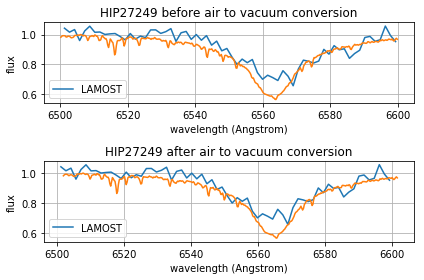

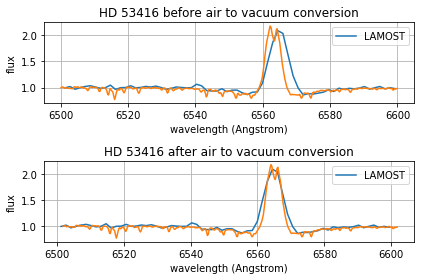

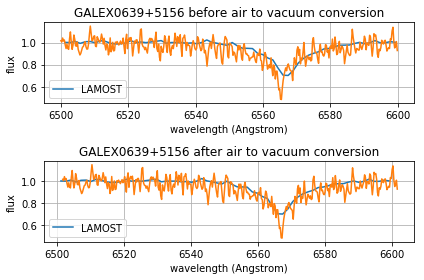

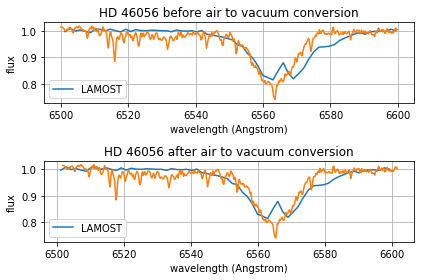

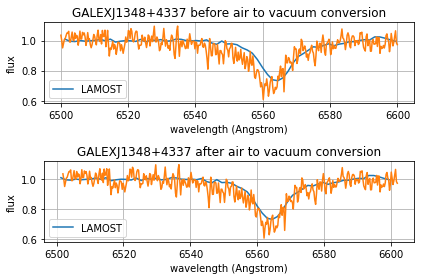

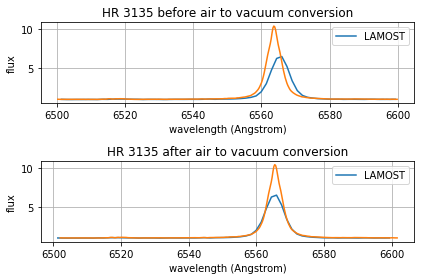

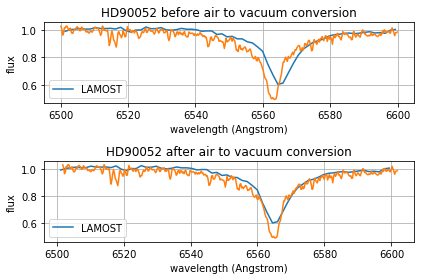

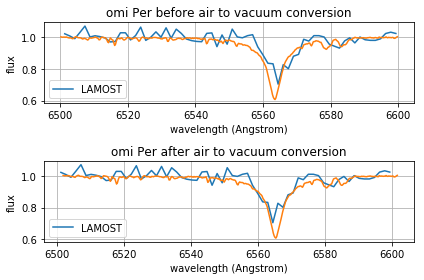

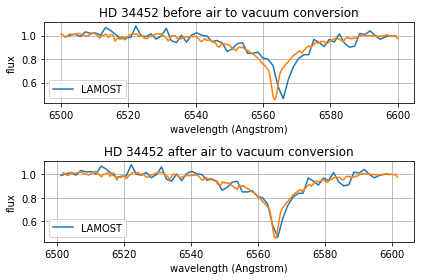

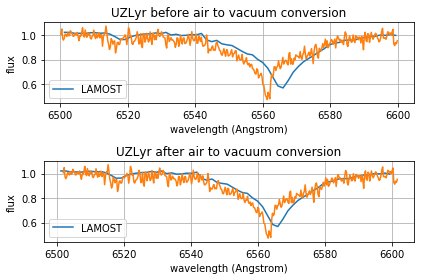

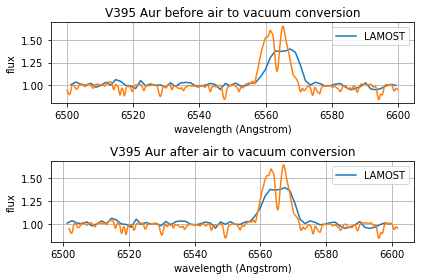

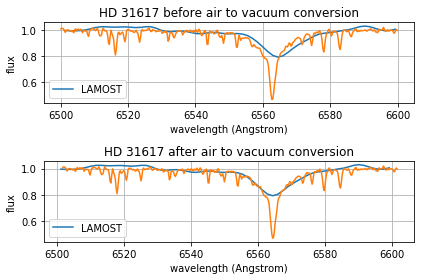

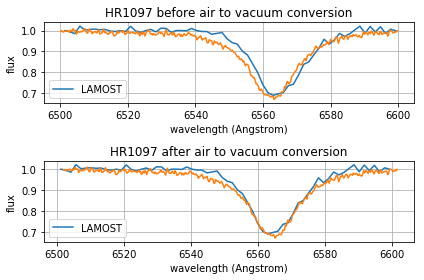

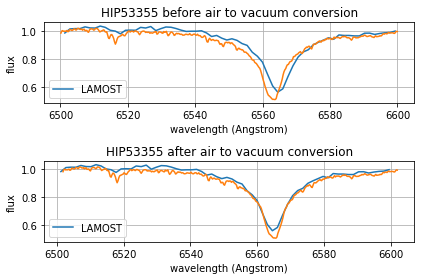

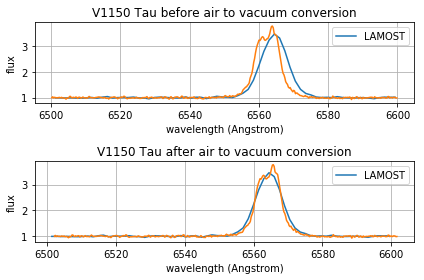

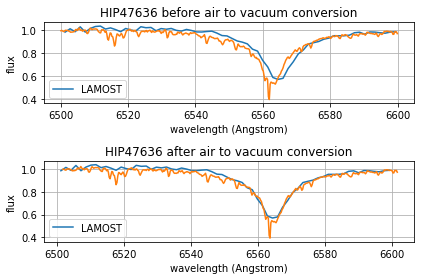

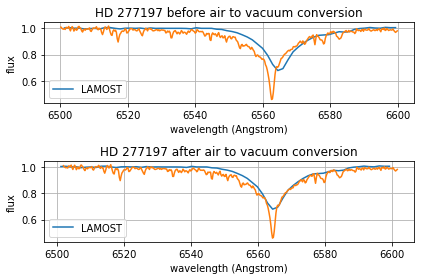

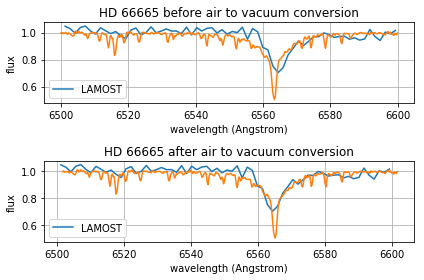

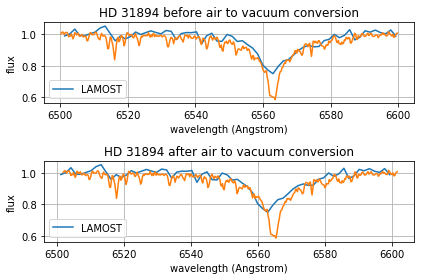

In [5]:
for name, data in spectra.items():
    fig, axs = plt.subplots(2, 1)
    ax1, ax2 = axs
    
    ax1.set_title(name + ' before air to vacuum conversion')
    ax2.set_title(name + ' after air to vacuum conversion')
    
    for ax in axs:
        ax.plot(data['lam']['waves'], data['lam']['fluxes'], label='LAMOST')
        ax.legend()
        ax.set_xlabel('wavelength (Angstrom)')
        ax.set_ylabel('flux')
        ax.grid()

    ax1.plot(data['ond']['waves'], data['ond']['fluxes'], label='Ondřejov')
    ond_vacuum_waves = preprocessing.air2vacuum(data['ond']['waves'])
    ax2.plot(ond_vacuum_waves, data['ond']['fluxes'], label='Ondřejov')
    
    fig.tight_layout()
    plt.show()

## Convolution

**Dead end:** Area under a curve won't work for determing the standard deviation of Gaussian kernel.

LAMOST and Ondřejov spectragraphs has different spectral resolving powers.
LAMOST has between 500-1800 while Ondřejov has about 13000.
That means the spectra from LAMOST are blurred.
Therefore Gaussian blur should be applied to Ondřejov spectra to remove the detail LAMOST cannot capture.

[Gaussia blur](https://en.wikipedia.org/wiki/Gaussian_blur) has primarily standard deviation paramater
which needs to be determined. **But that's incredibly hard to do correctly.**

Care only about shape not intensities because the classification was done according to shape.

### Gaussian Kernel

((57,), array([  1.91186037e-05,   3.35114230e-05,   5.75527945e-05,
          9.68449122e-05,   1.59670267e-04,   2.57933730e-04,
          4.08252708e-04,   6.33121202e-04,   9.62014211e-04,
          1.43223065e-03,   2.08920612e-03,   2.98597703e-03,
          4.18146515e-03,   5.73729721e-03,   7.71299522e-03,
          1.01595769e-02,   1.31118820e-02,   1.65802581e-02,
          2.05425518e-02,   2.49375820e-02,   2.96613654e-02,
          3.45672464e-02,   3.94707408e-02,   4.41593444e-02,
          4.84068480e-02,   5.19909602e-02,   5.47123943e-02,
          5.64131628e-02,   5.69917543e-02,   5.64131628e-02,
          5.47123943e-02,   5.19909602e-02,   4.84068480e-02,
          4.41593444e-02,   3.94707408e-02,   3.45672464e-02,
          2.96613654e-02,   2.49375820e-02,   2.05425518e-02,
          1.65802581e-02,   1.31118820e-02,   1.01595769e-02,
          7.71299522e-03,   5.73729721e-03,   4.18146515e-03,
          2.98597703e-03,   2.08920612e-03,   1.43223065e-03,
 

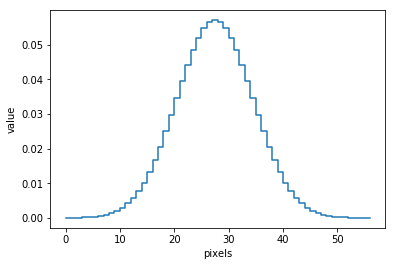

In [6]:
kernel = Gaussian1DKernel(stddev=7)

plt.plot(kernel, drawstyle='steps')
plt.xlabel('pixels')
plt.ylabel('value')

kernel.shape, kernel.array

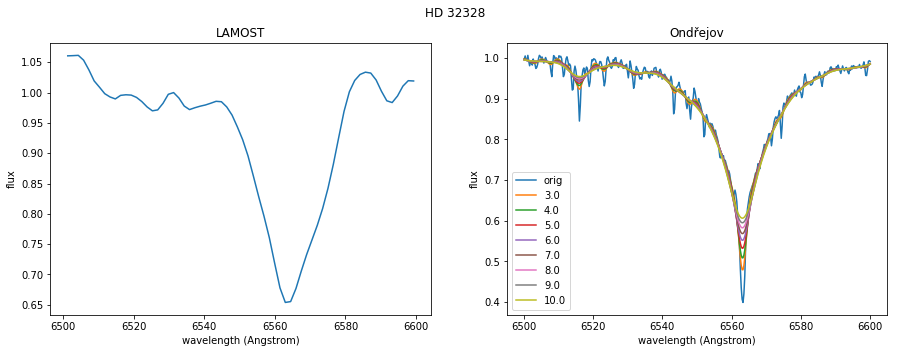

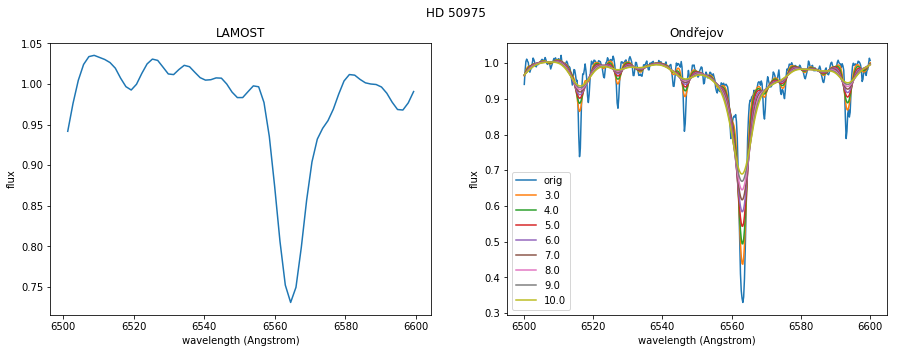

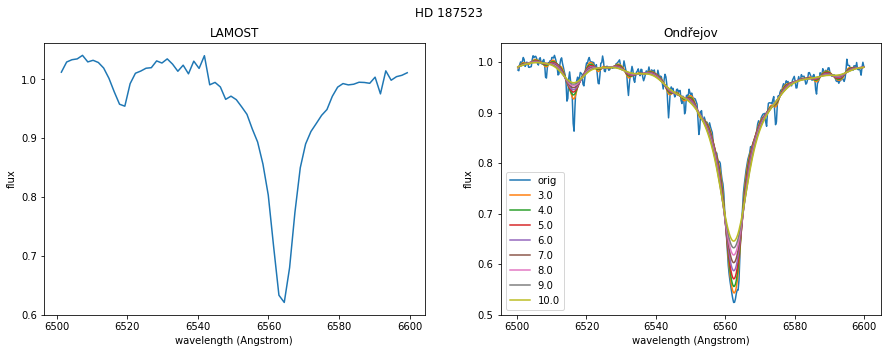

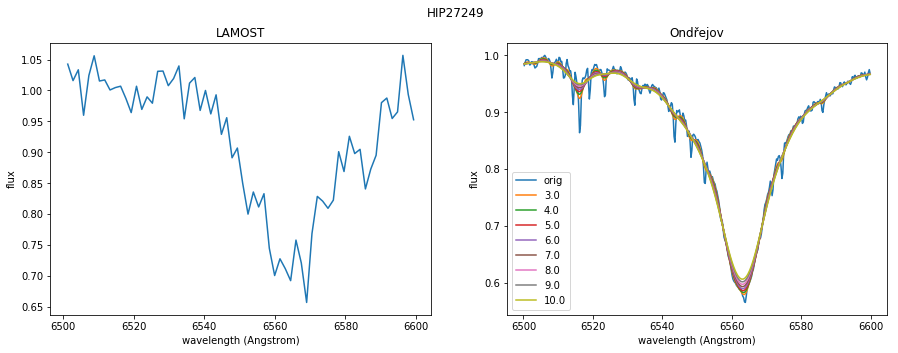

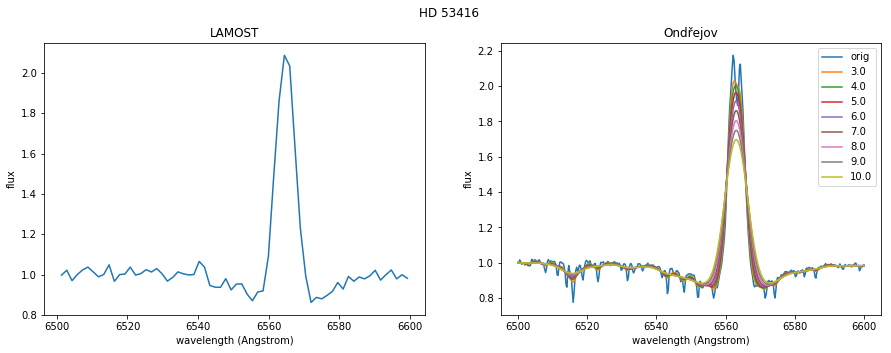

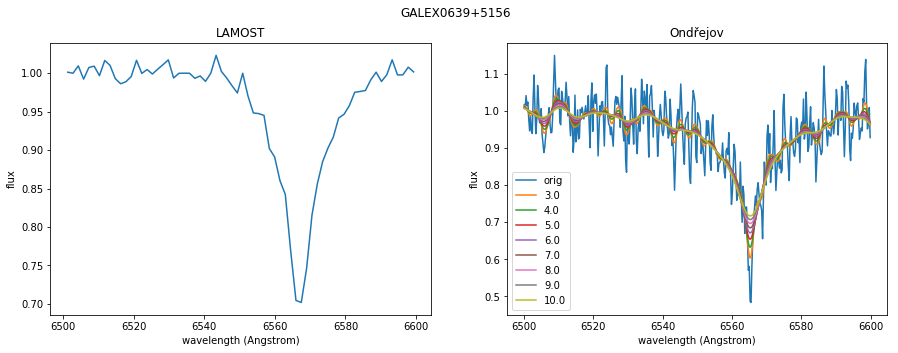

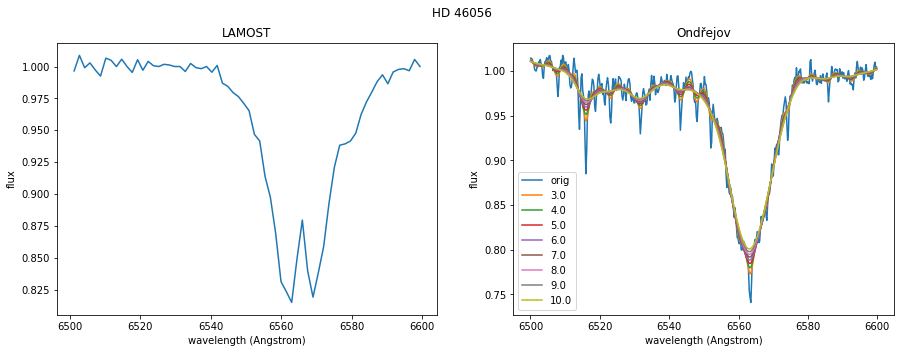

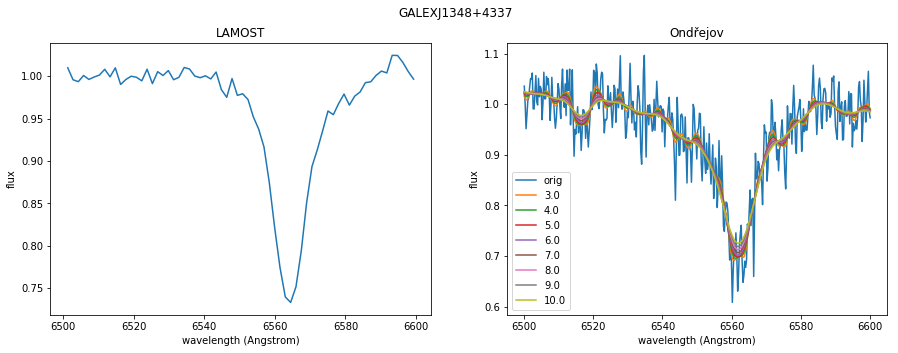

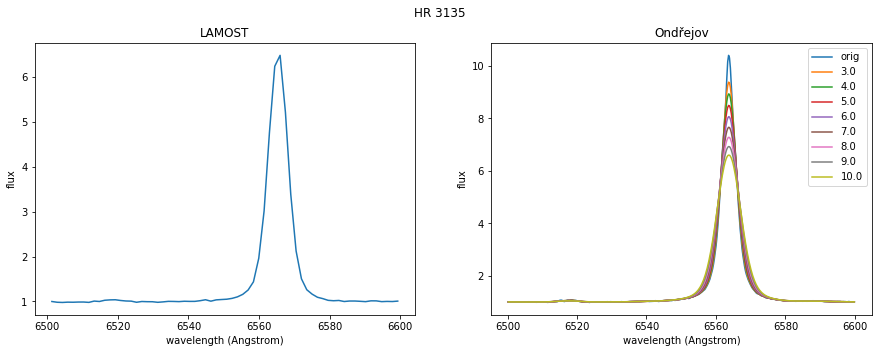

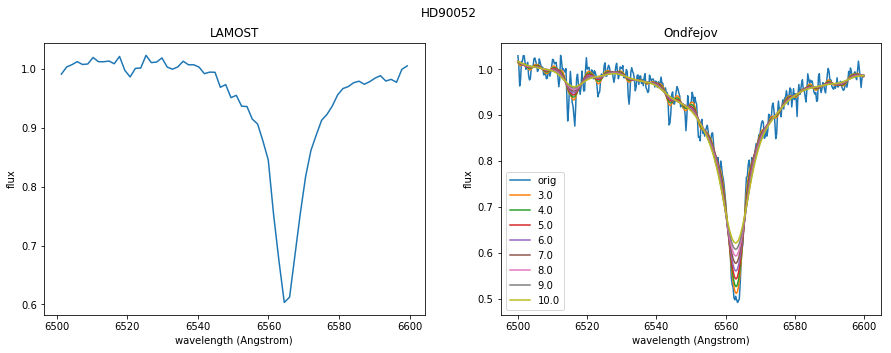

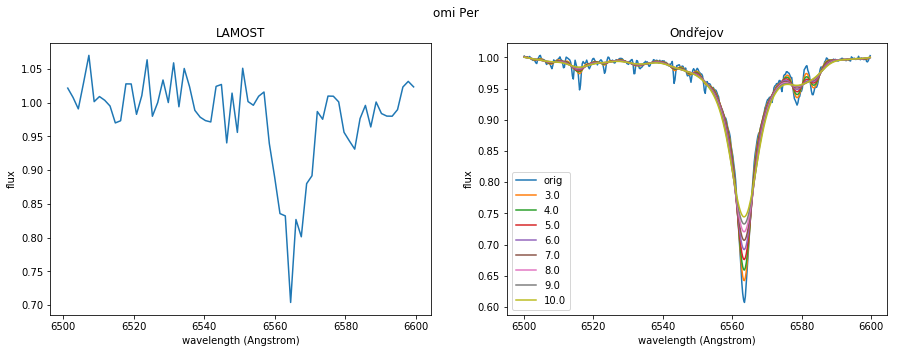

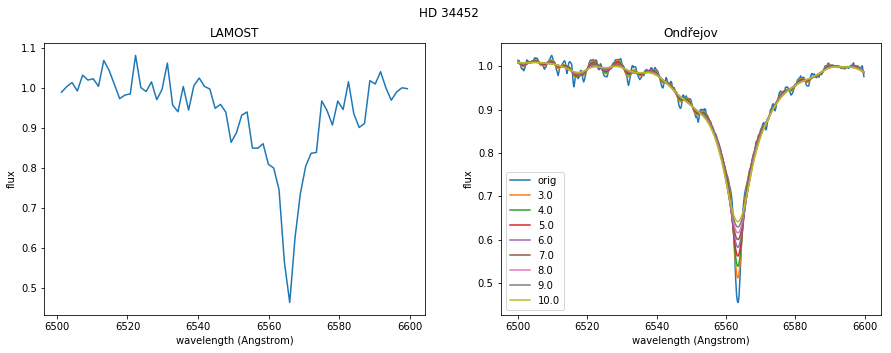

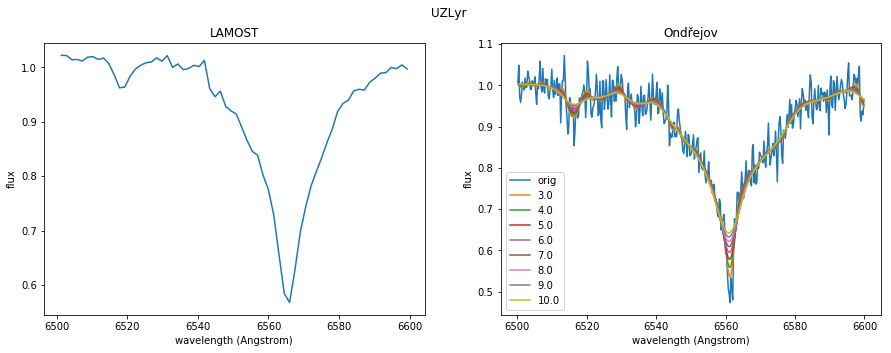

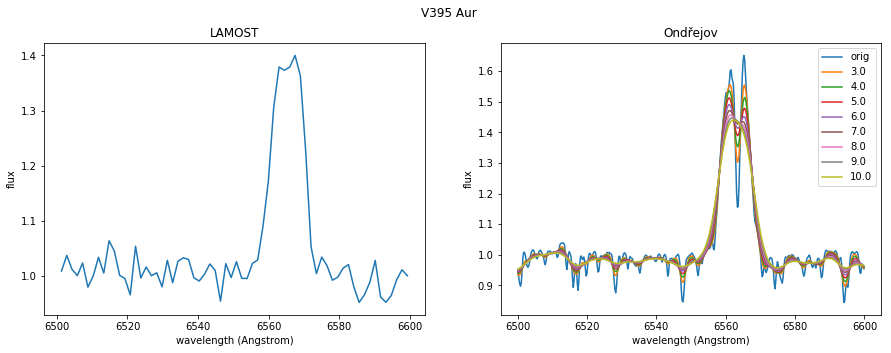

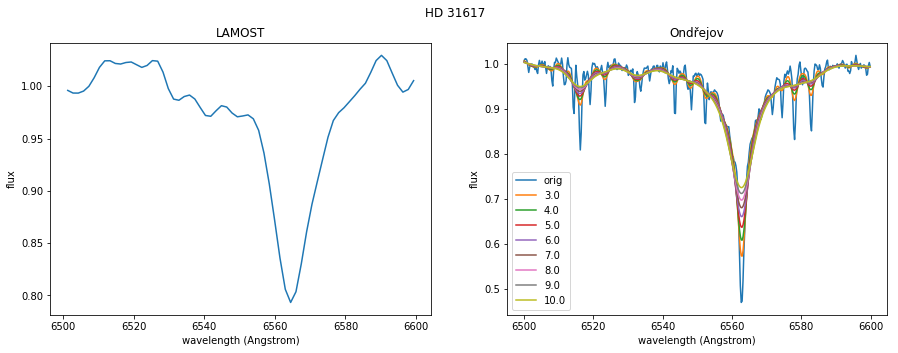

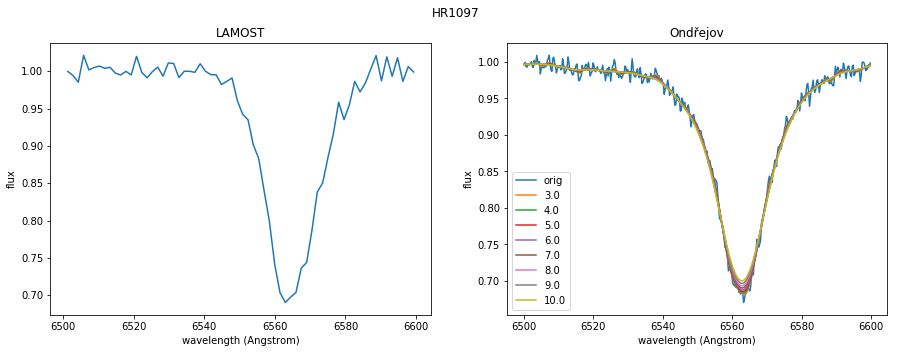

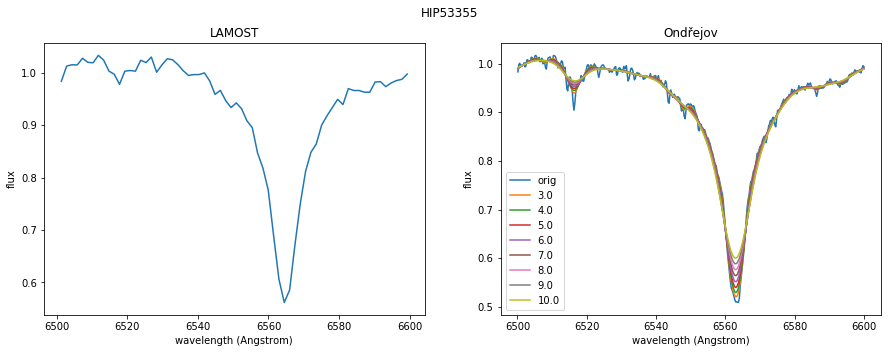

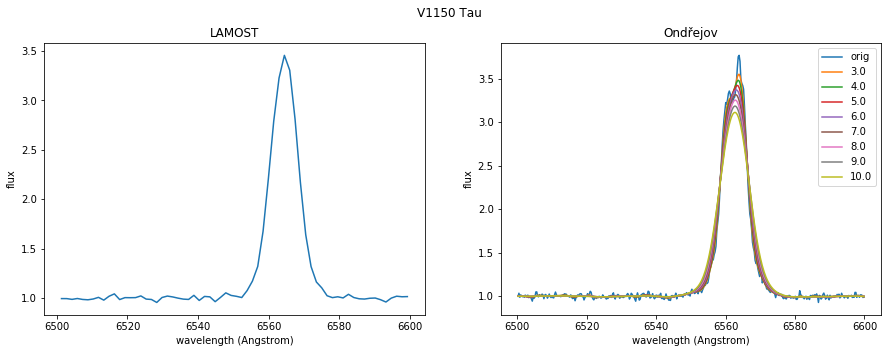

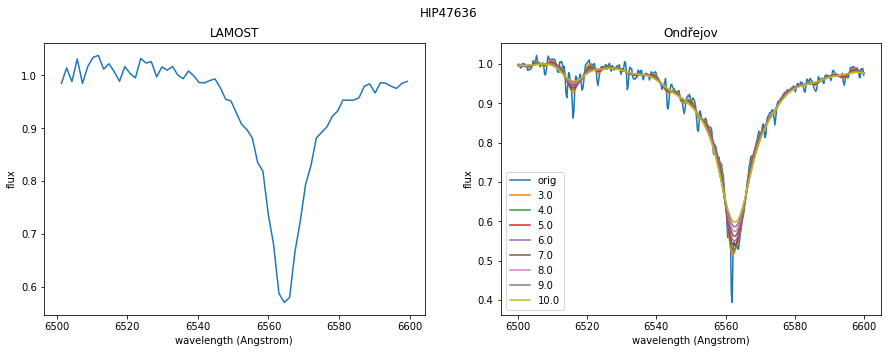

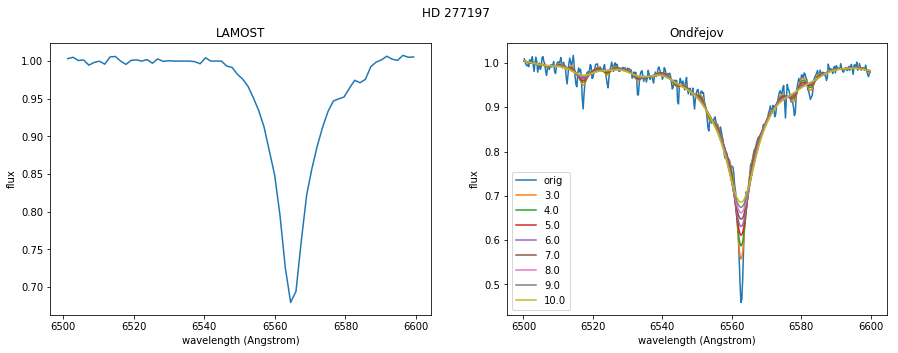

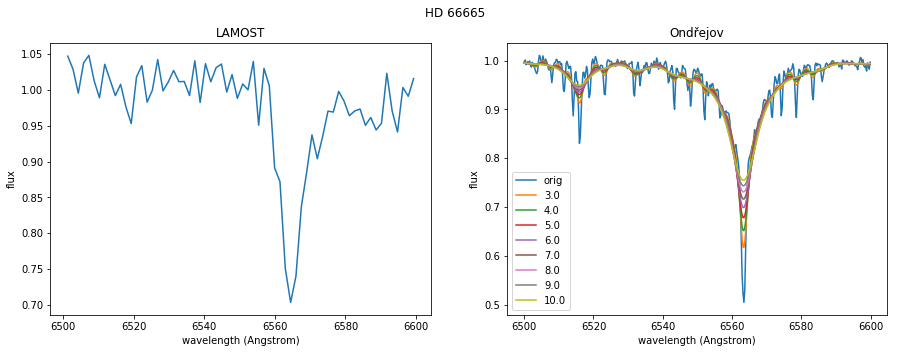

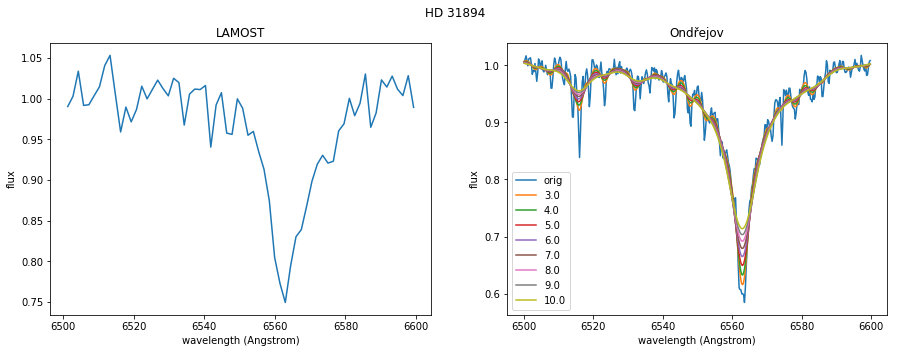

In [7]:
for name, data in spectra.items():        
    ond_vacuum_waves = preprocessing.air2vacuum(data['ond']['waves'])
    
    # plot them aside because we care only about intesities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(name)
    
    ax1.set_title('LAMOST')
    ax1.set_ylabel('flux')
    ax1.set_xlabel('wavelength (Angstrom)')
    ax2.set_title('Ondřejov')
    ax2.set_ylabel('flux')
    ax2.set_xlabel('wavelength (Angstrom)')

    ax1.plot(data['lam']['waves'], data['lam']['fluxes'], label='LAMOST')
    ax2.plot(data['ond']['waves'], data['ond']['fluxes'], label='orig')

    # try different gaussian blurs
    for stddev in np.linspace(3, 10, num=8):
        kernel = Gaussian1DKernel(stddev)
        ond_conv_fluxes = convolve(data['ond']['fluxes'], kernel, boundary='extend')
        ax2.plot(data['ond']['waves'], ond_conv_fluxes, label=str(stddev))

    ax2.legend()
    plt.show()

## Publication Plot

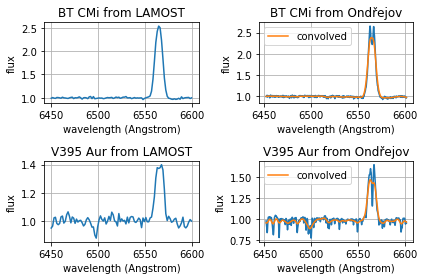

In [8]:
START, END = 6450, 6600
fig, axs = plt.subplots(2, 2)
ax1, ax2, ax3, ax4 = axs.ravel()

with fits.open('samples/bt-cmi-lamost.fits') as hdulist:
    waves, fluxes = utils.cut_spectrum(
        *lamost.get_spectrum(hdulist),
        START, END
    )
    ax1.plot(waves, fluxes)
    
with fits.open('samples/bt-cmi-ondrejov.fits') as hdulist:
    waves, fluxes = utils.cut_spectrum(
        *ondrejov.get_spectrum(hdulist),
        START, END
    )
    name_bt_cmi = ondrejov.get_object_name(hdulist)
    vacuum_waves = preprocessing.air2vacuum(waves)
    ax2.plot(vacuum_waves, fluxes)
    conv_fluxes = preprocessing.convolve_spectrum(fluxes)
    ax2.plot(vacuum_waves, conv_fluxes, label='convolved')
    
with fits.open('data/cross-matched/lamost/spec-55959-GAC_094N27_V3_sp16-125.fits') as hdulist:
    waves, fluxes = utils.cut_spectrum(
        *lamost.get_spectrum(hdulist),
        START, END
    )
    ax3.plot(waves, fluxes)
    
with fits.open('data/cross-matched/ondrejov/a201504150031.fits') as hdulist:
    waves, fluxes = utils.cut_spectrum(
        *ondrejov.get_spectrum(hdulist),
        START, END
    )
    name_v395_aur = ondrejov.get_object_name(hdulist)
    vacuum_waves = preprocessing.air2vacuum(waves)
    ax4.plot(vacuum_waves, fluxes)
    conv_fluxes = preprocessing.convolve_spectrum(fluxes)
    ax4.plot(vacuum_waves, conv_fluxes, label='convolved')

ax1.set_title(name_bt_cmi + ' from LAMOST')
ax2.set_title(name_bt_cmi + ' from Ondřejov')
ax3.set_title(name_v395_aur + ' from LAMOST')
ax4.set_title(name_v395_aur + ' from Ondřejov')
    
for ax in axs.ravel():
    ax.set_xlabel('wavelength (Angstrom)')
    ax.set_ylabel('flux')
    ax.grid()

ax2.legend()
ax4.legend()

fig.tight_layout()